In [1]:
# -*- coding: utf-8 -*-

from sklearn import datasets
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import KFold
import umap


def digits(method='svd', n_components=2):
    """Load digits dataset in sklearn.

    Args:
        method: 'svd' - Truncated SVD, 'umap' - UMAP. Default: 'svd'.
        n_components: Dimension of the embedded space. Default: 2.
    """
    # Load data
    data = datasets.load_digits()
    def data_split(start_index, end_index):
        dataset = data['data'][data['target'].argsort()][start_index:end_index]
        label = data['target'][data['target'].argsort()][start_index:end_index]
        return dataset, label

    zero_data, zero_label = data_split(0, 160)
    one_data, one_label = data_split(177 + 1, 177 + 161)
    data = np.vstack((zero_data, one_data))
    label = np.hstack((zero_label, one_label))

    # Dimension reduction
    assert method == 'svd' or method == 'umap', f'Invalid method parameter {method}.'
    if method == 'svd':
        fitter = TruncatedSVD(n_components=n_components)
    else:
        fitter = umap.UMAP(n_components=n_components)
    data = fitter.fit_transform(data)
    data = data / np.abs(data).max()
    data = np.concatenate((data, np.expand_dims(label, axis=-1)), axis=1)
    np.random.seed(42)
    np.random.shuffle(data)
    return {'X': data[:, :n_components], 'y': data[:, n_components].astype(int)}


def moons():
    """Load make_moons dataset in sklearn.
    """
    # Load data
    data = datasets.make_moons(n_samples=200, random_state=42)
    label = data[1]
    data = data[0]
    data = data / np.abs(data).max()
    return {'X': data, 'y': label}


def cancer(method='svd', n_components=2):
    """Load breast cancer dataset in sklearn.

    Args:
        method: 'svd' - Truncated SVD, 'umap' - UMAP. Default: 'svd'.
        n_components: Dimension of the embedded space. Default: 2.
    """
    # Load data
    data_arr = datasets.load_breast_cancer()
    data = data_arr['data']
    label = data_arr['target']

    # Dimension reduction
    assert method == 'svd' or method == 'umap', f'Invalid method parameter {method}.'
    if method == 'svd':
        fitter = TruncatedSVD(n_components=n_components)
    else:
        fitter = umap.UMAP(n_components=n_components)
    data = fitter.fit_transform(data)
    data = data / np.abs(data).max()
    return {'X': data, 'y': label}


def cross_validation_split(data, n_folds=5):
    """Prepare data for cross validation.

    Args:
        data: Format {'X': features, 'y': labels}.
        n_folds: The number of folds. Default: 5.
    """
    cv = list()
    kf = KFold(n_splits=n_folds)
    for i, (train_index, test_index) in enumerate(kf.split(data['X'])):
        cv.append({'train': {'X': data['X'][train_index, :],
                             'y': data['y'][train_index]},
                   'test': {'X': data['X'][test_index, :],
                             'y': data['y'][test_index]},
            })
    return cv

/home/fangtian/miniconda3/envs/qa/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# -*- coding: utf-8 -*-

import re
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import TwoLocal, PauliFeatureMap
from qiskit.providers.aer import QasmSimulator
from qiskit.circuit import Parameter


class VQC():
    """Implement parametrized quantum circuits.

    Args:
        data: Datasets. Format: {'train': {'X, 'y'}, 'test': {'X', 'y'}}
        n_qubits: The number of qubits. Default: 2.
        n_bits: The number of bits. Default: 2.
        feature_reps: The number of repetitions of the feature map. Default: 1.
        paulis: Define the feature map. Default: ['Z', 'ZZ'].
        ansatz_reps: The number of repetitions of the ansatz. Default: 1.
        n_shots: The number of shots. Default: 100.
        lr: Learning rate. Default: 0.1.
        epochs: Training epochs. Default: 3.
    """
    def __init__(self, data, n_qubits=2, n_bits=2, feature_reps=1, paulis=['Z', 'ZZ'], ansatz_reps=1, n_shots=100, lr=0.1, epochs=3):
        self.data = data
        self.n_qubits = n_qubits
        self.n_bits = n_bits
        self.feature_reps = feature_reps
        self.paulis = paulis
        self.ansatz_reps = ansatz_reps
        self.n_shots = n_shots
        self.lr = lr
        self.epochs = epochs

        self.initialization()

    def initialization(self):
        """Initialize the quantum circuit."""
        # Initialize the quantum circuit
        self.pauli_feature_map = self.set_feature_map()
        self.ansatz = self.set_ansatz()
        self.circuit = self.construct_circuit(plot=True)

        # Initialize parameters in the ansatz
        self.params = np.random.random(self.ansatz.num_parameters)

    def set_feature_map(self, plot=False):
        """Feature map circuit."""
        if self.n_qubits == 4:
            pauli_feature_map = QuantumCircuit(4)
            params = [Parameter(f'x[{i}]') for i in range(4)]
            for i in range(4):
                pauli_feature_map.h(i)
                pauli_feature_map.p(2 * params[i], i)
            pauli_feature_map.cx(0, 1)
            pauli_feature_map.p(2 * (np.pi - params[0]) * (np.pi - params[1]), 1)
            pauli_feature_map.cx(0, 1)
            pauli_feature_map.cx(1, 2)
            pauli_feature_map.cx(2, 3)
            pauli_feature_map.p(2 * (np.pi - params[2]) * (np.pi - params[3]), 3)
            pauli_feature_map.cx(2, 3)
        else:
            pauli_feature_map = PauliFeatureMap(
                    feature_dimension=self.n_qubits, 
                    reps=self.feature_reps, 
                    paulis=self.paulis).decompose()
        if plot:
            pauli_feature_map.draw(output="mpl")
            plt.show()
        return pauli_feature_map

    def set_ansatz(self, plot=False):
        """Ansatz circuit."""
        ansatz = TwoLocal(
                num_qubits=self.n_qubits,
                rotation_blocks=['rz', 'ry'],
                entanglement_blocks='cz',
                entanglement='circular',
                reps=self.ansatz_reps).decompose()
        if plot:
            ansatz.draw(output="mpl")
            plt.show()
        return ansatz

    def construct_circuit(self, plot=False):
        """Create the variational circuit."""
        circuit = QuantumCircuit(self.n_qubits, self.n_bits)
        circuit = circuit.compose(
                self.pauli_feature_map,
                list(range(self.n_qubits)))
        circuit = circuit.compose(
                self.ansatz,
                list(range(self.n_qubits)))
        circuit.measure(
                list(range(self.n_qubits)),
                list(range(self.n_bits))
                )
        if plot:
            circuit.draw(output="latex")
        return circuit

    def predict(self, _circuit, X, params):
        """Predict one record."""
        values = {**dict(zip(self.pauli_feature_map.parameters, X)),
                **dict(zip(self.ansatz.parameters, params))}
        circuit = _circuit.assign_parameters(values, inplace=False)
        simulator = QasmSimulator()
        compiled_circuit = transpile(circuit, simulator)
        job = simulator.run(compiled_circuit, shots=self.n_shots)
        
        result = job.result()
        counts = result.get_counts(compiled_circuit)
        distribution = np.zeros(self.n_bits).tolist()
        for key in counts.keys():
            checker = sum([int(i) for i in re.findall('\d', key)])
            if (checker % 2) == 0:
                distribution[0] += counts[key]
            else:
                distribution[1] += counts[key]
        output = distribution[0] / (distribution[0] + distribution[1])
        return output

    def gradient_descent(self, _circuit, X, y, params):
        """Optimize the parameter with Gradient Descent algorithm."""
        def loss(_circuit, X, y, params):
            return np.abs(self.predict(_circuit, X, params) - y)

        def subroutine(_circuit, X, y, index, params):
            e_i = np.identity(params.size)[:, index]
            plus = params + (np.pi / 2) * e_i
            minus = params - (np.pi / 2) * e_i
            return (loss(_circuit, X, y, plus) - loss(_circuit, X, y, minus)) / 2

        for index in range(len(params)):
            params[index] -= self.lr * subroutine(_circuit, X, y, index, params)
        return params

    def visualization(self, _circuit):
        """Visualize results when dim(X) == 2."""
        assert self.data['test']['X'].shape[1] == 2, 'Dimension of features must be 2.'
        plt.figure()
        cm = plt.cm.RdBu

        # Decision regions
#       xx, yy = np.meshgrid(np.linspace(0.4, 1.1, 50), np.linspace(-0.5, 0.5, 50)) # digits
#       xx, yy = np.meshgrid(np.linspace(-0.6, 1.1, 50), np.linspace(-0.3, 0.5, 50)) # moons
        xx, yy = np.meshgrid(np.linspace(0, 1.1, 50), np.linspace(-0.2, 0.2, 50)) # breast cancer
        X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
        predictions_grid = [self.predict(_circuit, f, self.params) for f in X_grid]
        Z = np.reshape(predictions_grid, xx.shape)
        cnt = plt.contourf(xx, yy, Z, levels=np.arange(0, 1.1, 0.1), cmap=cm, alpha=0.8, extend='both')
        plt.contour(xx, yy, Z, levels=[0.0], colors=('black',), linestyles=('--',), linewidths=(0.8,))
        plt.colorbar(cnt, ticks=[0, 0, 1])

        X_te = self.data['test']['X']
        y_te = self.data['test']['y']
        labels = np.unique(y_te).tolist()

        # Plot data
        plt.scatter(
            X_te[:, 0][y_te == labels[0]],
            X_te[:, 1][y_te == labels[0]],
            c='r',
            marker='^',
            edgecolors='k',
            label=f'class {labels[0]}',
        )
        plt.scatter(
            X_te[:, 0][y_te == labels[1]],
            X_te[:, 1][y_te == labels[1]],
            c='b',
            marker='^',
            edgecolors='k',
            label=f'class {labels[1]}',
        )
        plt.legend()
        plt.show()

    def main(self):
        """Training and evaluation."""
        train = self.data['train']
        test = self.data['test']

        for epoch in range(self.epochs):
            print(f'\nEpoch: {epoch + 1}\nTraining...')
            for n in tqdm(range(len(train['y']))):
                self.params = self.gradient_descent(self.circuit, train['X'][n], train['y'][n], self.params)
            print('Evaluating...')
            predictions = list()
            for n in range(len(test['y'])):
                output = self.predict(self.circuit, test['X'][n], self.params)
                if output < 0.5:
                    predictions.append(0)
                else:
                    predictions.append(1)
            predictions = np.array(predictions)
            print(f'Test acc: {(predictions == test["y"]).sum() / len(predictions)}')


if __name__ == '__main__':
#   # n_qubits = 2
#   ## digits
    data = digits(method='svd', n_components=2)
#   five_fold_cross_validation(data)

#   ## make_moons
#   data = moons()
#   five_fold_cross_validation(data)

#   ## breast_cancer
#   data = cancer(method='svd', n_components=2)
#   five_fold_cross_validation(data)

    # n_qubits = 4
    ## digits
#   data = digits(method='svd', n_components=4)

#   ## breast_cancer
#   data = cancer(method='svd', n_components=4)
#   five_fold_cross_validation(data, n_qubits=4, n_bits=4, visual=False)

In [3]:
cv_lst = cross_validation_split(data, n_folds=5)
model = VQC(cv_lst[0], n_qubits=2, n_bits=2, epochs=3, n_shots=1000, lr=0.1)

In [4]:
circ = model.construct_circuit(plot=True)

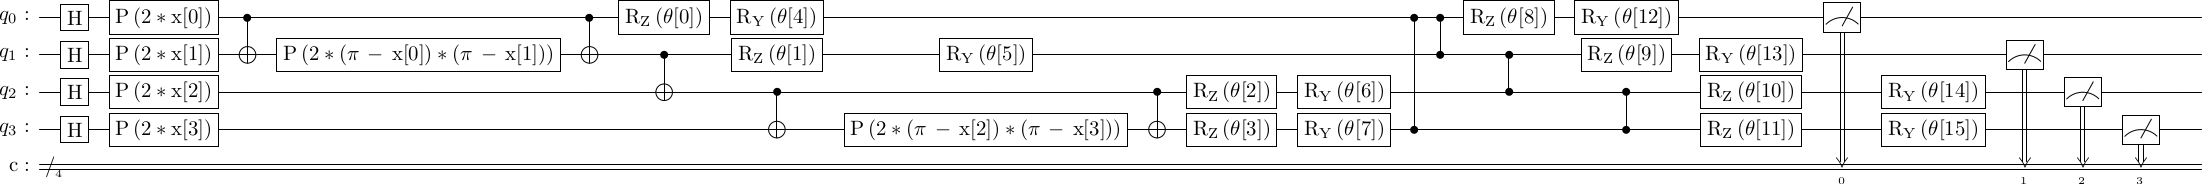

In [13]:
circ.draw(output="latex", filename='/home/fangtian/Documents/work/2022Fall/Quantum Algorithms/project/quantum-algorithms-project/large-circuit-4.png')

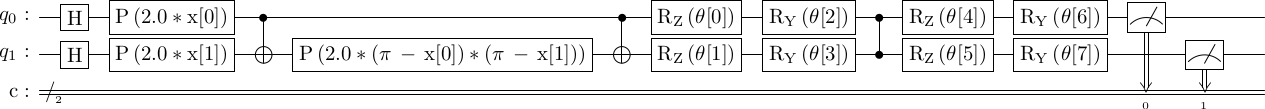

In [5]:
circ.draw(output="latex", filename='/home/fangtian/Documents/work/2022Fall/Quantum Algorithms/project/quantum-algorithms-project/large-circuit-2.png')

In [14]:
# -*- coding: utf-8 -*-

from qiskit.circuit.library import TwoLocal
from qiskit import circuit


class Partition1(VQC):
    """Implement circuit partition strategy in paper: High Dimensional Quantum Machine Learning With Small Quantum Computers. (arXiv:2203.13739v)"""
    def __init__(self, data, n_qubits=2, n_bits=2, feature_reps=1, paulis=['Z', 'ZZ'], ansatz_reps=1, n_shots=100, lr=0.1, epochs=3, L=1):
        self.L = L
        super().__init__(data, n_qubits, n_bits, feature_reps, paulis, ansatz_reps, n_shots, lr, epochs)

    def initialization(self):
        """Initialize the quantum circuit."""
        # Initialize the quantum circuit
        self.pauli_feature_map = self.set_feature_map()
        self.ansatz = self.set_ansatz()
        small_circuit1 = self.construct_circuit(plot=False)
        small_circuit2 = self.construct_circuit(plot=False)
        self.circuit = [small_circuit1, small_circuit2]

        # Initialize parameters
        params1 = np.random.random((self.L, self.ansatz.num_parameters))
        params2 = np.random.random((self.L, self.ansatz.num_parameters))
        weights = np.random.random(2 * self.L)
        self.params = [params1, params2, weights]

    def set_ansatz(self, plot=False):
        """Ansatz circuit."""
        ansatz = TwoLocal(
                num_qubits=self.n_qubits,
                rotation_blocks=['rz', 'ry'],
                entanglement_blocks='cz',
                reps=self.ansatz_reps).decompose()
        ansatz.rz(circuit.Parameter('xi[0]'), 0)
        ansatz.rz(circuit.Parameter('xi[1]'), 1)
        if plot:
            ansatz.draw(output="mpl")
            plt.show()
        return ansatz

    def predict(self, _circuit, X, params):
        """Predict one record."""
        result1 = list()
        result2 = list()
        for i in range(self.L):
            result1.append(super().predict(_circuit[0], X, params[0][i, :]))
            result2.append(super().predict(_circuit[1], X, params[1][i, :]))
        return np.sum(params[2] * np.array(result1 + result2))

    def gradient_descent(self, _circuit, X, y, params):
        """Optimize the parameter with Gradient Descent algorithm."""
        def loss(_circuit, X, y, params):
            return np.abs(self.predict(_circuit, X, params) - y)

        def subroutine(_circuit, X, y, index_i, index_j, params, l=-1):
            if l != -1:
                params_target = params[index_i][l, :]
            else:
                params_target = params[index_i]
            e_i = np.identity(params_target.size)[:, index_j]
            plus = params_target + (np.pi / 2) * e_i
            minus = params_target - (np.pi / 2) * e_i
            plus_lst = list()
            minus_lst = list()
            for k in range(len(params)):
                if k == index_i:
                    if l != -1:
                        plus_arr = params[index_i].copy()
                        plus_arr[l, :] = plus
                        minus_arr = params[index_i].copy()
                        minus_arr[l, :] = minus
                        plus_lst.append(plus_arr)
                        minus_lst.append(minus_arr)
                    else:
                        plus_lst.append(plus)
                        minus_lst.append(minus)
                else:
                    plus_lst.append(params[k])
                    minus_lst.append(params[k])
            return (loss(_circuit, X, y, plus_lst) - loss(_circuit, X, y, minus_lst)) / 2

        for i in range(len(params)):
            if i < 2:
                for l in range(self.L):
                    for j in range(len(params[i])):
                        params[i][l, j] -= self.lr * subroutine(_circuit, X, y, i, j, params, l)
            else:
                for j in range(len(params[i])):
                    params[i][j] -= self.lr * subroutine(_circuit, X, y, i, j, params, -1)

        return params


if __name__ == '__main__':
    # digits
    data = digits(method='svd', n_components=4)

    # breast_cancer
#   data = cancer(method='svd', n_components=4)

In [15]:
cv_lst = cross_validation_split(data, n_folds=5)
model = Partition1(cv_lst[0], n_qubits=2, n_bits=2, epochs=3, lr=0.1, L=2, n_shots=1000)

In [16]:
circ = model.construct_circuit(plot=True)

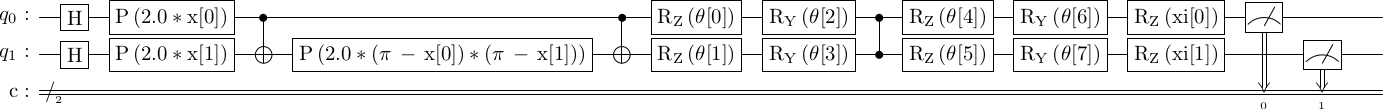

In [17]:
circ.draw(output="latex", filename='/home/fangtian/Documents/work/2022Fall/Quantum Algorithms/project/quantum-algorithms-project/small-circuit.png')